In [1]:
from pygeo import encode
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import math

from scipy import stats

#GET DATA + DROPPING IRRELEVANT COLUMNS ID AND DATE
datafile =  r"data.csv"
df = pd.read_csv(datafile)
df = df.drop(['id', 'date'],axis=1)
zero_bathr = df["bathrooms"] == 0
zero_bedr = df["bedrooms"] == 0
df = df.drop(df[zero_bathr | zero_bedr].index)

old = len(df)
print("rows before removing outliers: ", old, " rows")
#df = df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3.5).all(axis=1)]
columns_to_trim = ['sqft_living', 'sqft_lot','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for column in columns_to_trim:
    df = df[(np.abs(stats.zscore(df[column])) < 3.5)]

outliers_price = df["price"] > 6_000_000
outliers_sqft15 = df["sqft_lot15"] > 500_000
outliers_sqft = df["sqft_lot"] > 1.5e6
lving = df["sqft_living"] > 12_000
basement = df["sqft_basement"] > 4500
df = df.drop(df[outliers_price | outliers_sqft | lving | outliers_sqft15 |basement].index)

print(old-len(df), "rows were removed")
print("rows after removing outliers: ", len(df), "rows")


rows before removing outliers:  21596  rows
959 rows were removed
rows after removing outliers:  20637 rows


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split # Import train_test_split function
#standardization scaler - fit&transform on train, fit only on test
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


X = df.iloc[:,1:]
y = df.iloc[:,0]

els = [[el] for el in list(df.columns)]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=101)

s_scaler = MinMaxScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test = s_scaler.transform(X_test.astype(np.float))

In [3]:

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': [1500,1800,2000,2500],
               'max_features': ['auto'],
               'max_depth': [50,75,100],
               'min_samples_split': [2,4,5],
               'min_samples_leaf': [2,3],
               'bootstrap': [True]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(n_jobs = -1)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1500; total time=  32.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1500; total time=  29.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1500; total time=  29.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  35.3s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  35.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1800; total time=  35.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_iter=100,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 75, 100],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3],
                                        'min_samples_split': [2, 4, 5],
                                        'n_estimators': [1500, 1800, 2000,
                                                         2500]},
                   random_state=42, verbose=2)

In [8]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [23]:
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)

    from sklearn import metrics
    import matplotlib.ticker as mticker    
    plt.rcParams['figure.dpi'] = 100

    metrics_mae = metrics.mean_absolute_error(test_labels, y_pred)
    metrics_mse = metrics.mean_squared_error(test_labels, y_pred)
    metrics_mae_sqrt = np.sqrt(metrics.mean_absolute_error(test_labels, y_pred))
    metrics_evs =  metrics.explained_variance_score(test_labels, y_pred)
    r2 = metrics.r2_score(test_labels, y_pred)
    print('MAE:', metrics_mae)  
    print('MSE:', metrics_mse)  
    print('RMSE:', metrics_mae_sqrt)
    print('VarScore:',metrics_evs)
    print('r2: ', r2)
    # Visualizing Our predictions
    fig = plt.figure(figsize=(10,5))
    ax = plt.scatter(test_labels,y_pred)

    # Perfect predictions
    plt.plot(test_labels,test_labels,'r')
    plt.title("Scatterplot of predicted prices compared with real prices", fontsize=18)

    plt.xlabel('predicted prices', fontsize=18)
    plt.ylabel('real prices', fontsize=16)
    plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d $'))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d $'))

(6192, 18)
(6192,)
MAE: 63027.0388054949
MSE: 11708962184.335812
RMSE: 251.05186477199268
VarScore: 0.8779028187663023
r2:  0.877893486590237


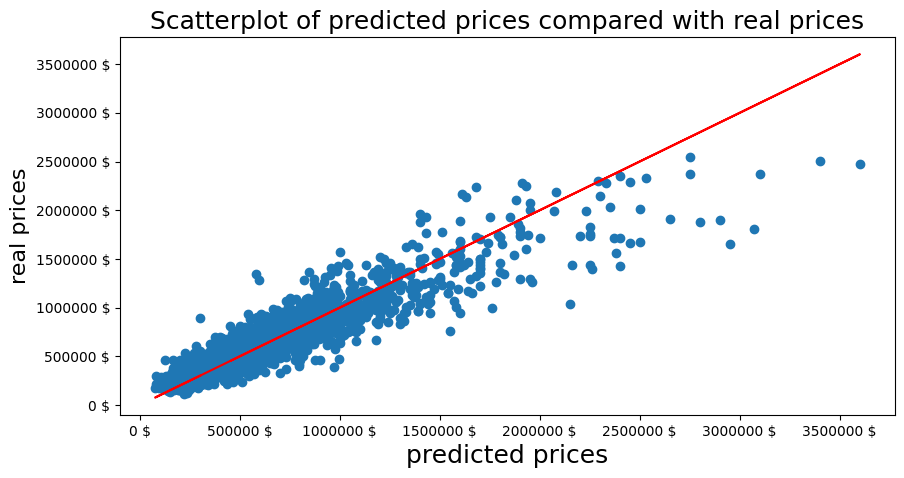

In [25]:
best_random = rf_random.best_estimator_
print(X_test.shape)
print(y_test.shape)
random_accuracy = evaluate(best_random, X_test, y_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 

n_estimators = [int(x) for x in np.linspace(start = 1800, stop = 2500, num = 100)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(40, 80, num = 10)]

min_samples_split = [4,5,6]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]


param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
             }

# Create a base model
rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2, return_train_score=True)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 9000 candidates, totalling 27000 fits
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1800; total time= 1.1min


In [35]:
# Grid with only the number of trees changed
from sklearn.model_selection import GridSearchCV

tree_grid = {'n_estimators': [int(x) for x in np.linspace(1500, 2500, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(best_random, param_grid=tree_grid, verbose = 2, cv = 3, return_train_score=True,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train, y_train);


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ..................................n_estimators=1500; total time=  49.8s
[CV] END ..................................n_estimators=1500; total time=  46.3s
[CV] END ..................................n_estimators=1500; total time=  46.3s
[CV] END ..................................n_estimators=1534; total time=  47.9s
[CV] END ..................................n_estimators=1534; total time=  47.3s
[CV] END ..................................n_estimators=1534; total time=  46.9s
[CV] END ..................................n_estimators=1568; total time=  48.5s
[CV] END ..................................n_estimators=1568; total time=  48.5s
[CV] END ..................................n_estimators=1568; total time=  48.0s
[CV] END ..................................n_estimators=1603; total time=  50.4s
[CV] END ..................................n_estimators=1603; total time=  50.2s
[CV] END ..................................n_est

In [ ]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4400
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(100*np.pi*10*t) + np.sin(2*np.pi*10*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [8]:
from matplotlib import pyplot as plt
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

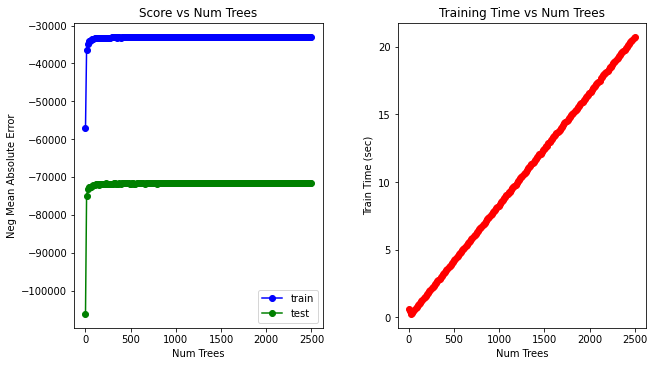

In [16]:
plot_results(tree_grid_search)
t

In [21]:
tree_grid_search.best_params_
tree_grid_search.best_estimator_.score(X_test,y_test)
tree_grid_search.best_estimator_

RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=2500, n_jobs=-1)

In [42]:
tree_grid_search.best_estimator_.score(X_test,y_test)


0.8673724052811992

In [47]:
RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=2465, n_jobs=-1,random_state=42)


RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=2465, n_jobs=-1, random_state=42)

In [52]:
rf = RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=2465, n_jobs=-1,random_state=42)
rf.fit(X_train, y_train)

print(rf.score(X_test,y_test))

0.8673176481608229


In [15]:
# Grid with only the number of trees changed
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
best_RF= RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,n_estimators=2465, n_jobs=-1)
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 2500, 200)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(best_RF, param_grid=tree_grid, verbose = 2, cv = 2, return_train_score=True,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train, y_train);


Fitting 2 folds for each of 200 candidates, totalling 400 fits
[CV] END .....................................n_estimators=1; total time=   0.8s
[CV] END .....................................n_estimators=1; total time=   0.5s
[CV] END ....................................n_estimators=13; total time=   0.9s
[CV] END ....................................n_estimators=13; total time=   0.3s
[CV] END ....................................n_estimators=26; total time=   0.4s
[CV] END ....................................n_estimators=26; total time=   0.4s
[CV] END ....................................n_estimators=38; total time=   0.5s
[CV] END ....................................n_estimators=38; total time=   0.5s
[CV] END ....................................n_estimators=51; total time=   0.6s
[CV] END ....................................n_estimators=51; total time=   0.6s
[CV] END ....................................n_estimators=63; total time=   0.7s
[CV] END ....................................n

In [14]:
tree_grid_search.cv_results_['mean_train_score']


AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [11]:
# Grid with only the number of trees changed
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
best_RF= RandomForestRegressor(max_depth=50, min_samples_leaf=2, min_samples_split=5,n_estimators=2465, n_jobs=-1)
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 100, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(best_RF, param_grid=tree_grid, verbose = 2, cv = 3, return_train_score=True,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END .....................................n_estimators=1; total time=   0.8s
[CV] END .....................................n_estimators=1; total time=   0.5s
[CV] END .....................................n_estimators=1; total time=   0.5s
[CV] END .....................................n_estimators=4; total time=   0.7s
[CV] END .....................................n_estimators=4; total time=   0.6s
[CV] END .....................................n_estimators=4; total time=   0.2s
[CV] END .....................................n_estimators=7; total time=   0.2s
[CV] END .....................................n_estimators=7; total time=   0.2s
[CV] END .....................................n_estimators=7; total time=   0.2s
[CV] END ....................................n_estimators=11; total time=   0.3s
[CV] END ....................................n_estimators=11; total time=   0.3s
[CV] END ....................................n_e

KeyboardInterrupt: 

In [7]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)